In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    auc, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
)
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold,
)
from yellowbrick.classifier import (
    ConfusionMatrix, 
    ROCAUC,
)
from yellowbrick.model_selection import (
    LearningCurve,
)

In [56]:
rc = {
    'axes.grid': False,
    'axes.edgecolor': 'lightgrey',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.color': 'grey',
    'xtick.labelsize': 'small',
    'xtick.bottom': True,
    'xtick.major.size': 2.5,
    'ytick.color': 'grey',
    'ytick.major.size': 2.5,
    'ytick.left': True
}

sns.set(style='whitegrid', rc=rc)

In [4]:
import sklearn, pandas, numpy
for lib in [sklearn, pandas, numpy]:
    print(lib.__name__, lib.__version__)

sklearn 0.23.1
pandas 1.0.5
numpy 1.18.5


### Getting the data

In [ ]:
url = ('http://biostat.mc.vanderbilt.edu/'
       'wiki/pub/Main/DataSets/titanic3.xls')
titanic_vandebilt = pd.read_excel(url)

### Initial data profiling

In [5]:
titanic_vandebilt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [8]:
from pandas_profiling import ProfileReport

profile = ProfileReport(titanic_vandebilt, 
                        title="Vanderbilt University Medical Center (VUMC) Titanic dataset",
                        explorative=True)

profile.to_widgets()

In [9]:
titanic = titanic_vandebilt.copy()

titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


### Exploring missing values

In [19]:
# Missing data in each collumn
titanic.isnull().sum().sort_values(ascending=False)

body         1188
cabin        1014
boat          823
home.dest     564
age           263
embarked        2
fare            1
ticket          0
parch           0
sibsp           0
sex             0
name            0
survived        0
pclass          0
dtype: int64

In [22]:
# Percentage of missing values in each collumn
titanic.isnull().mean().sort_values(ascending=False)

body         0.907563
cabin        0.774637
boat         0.628724
home.dest    0.430863
age          0.200917
embarked     0.001528
fare         0.000764
ticket       0.000000
parch        0.000000
sibsp        0.000000
sex          0.000000
name         0.000000
survived     0.000000
pclass       0.000000
dtype: float64

In [27]:
rows_with_nans = titanic.isnull().any(axis='columns')

rows_with_nans.head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [28]:
titanic.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

We could see from `pandas_profiling` report that **pclass** and **sex** are categorical features with no missing values. However **embarked** (Point of embarktion) has two missing values. We could deal with these missing values in several ways:
1. We could impute them with the most common value of this feature.
2. We could drop these two values
3. We could ignore them and let `pd.get_dummies()` encode them as all-zeroes.
The latter approach could be used with **cabin** as it is also categorical (although with high cardinality)

### Dropping (seemingly) uninformative or *leaky* columns

In [29]:
# For extracting titles later in the analysis
passanger_names = titanic.name

columns = [
    'name',
    'ticket',
    'home.dest',
    'boat', 
    'body',
    'cabin'
]

titanic = titanic.drop(columns=columns)

1. **name** - Unless we perform some kind of NLP and external analysis like what were the most common names for upper-class individuals (that we assume would buy more expensive tickets on the higher decks and thus more likely to reach the rescue boats faster, we will not be able to fully take advantage of this column. We will use it to extract titles in hopes of determining their status though.
2. **ticket** - External analysis could be used to determine which cabins (with their proximity to the main deck/rescue boats) were purchased last, or whether the ticket the passanger bought were in the lower levels that would make the evacuation harder. We will not be doing that analysis at this time.
3. **home.dest** - Could be used similarly like the **ticket** column as described above.
4. **boat** - *Leaky* feature that indicates that the passanger was on a rescue boat.
5. **body** - *Leaky* feature that indicates that the passanger's body was found.
6. **cabin** - Could be used to determine the proximity to rescue boats but will not be used this analysis' current form.

### Creating dummy columns

In [31]:
titanic = pd.get_dummies(titanic).drop(columns='sex_male')

titanic.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [33]:
import janitor

X, y = janitor.ml.get_features_targets(titanic, target_columns='survived')

### Creating train and test sets

In [ ]:
def survival_proportions(data):
    return data.survived.value_counts() / len(data)

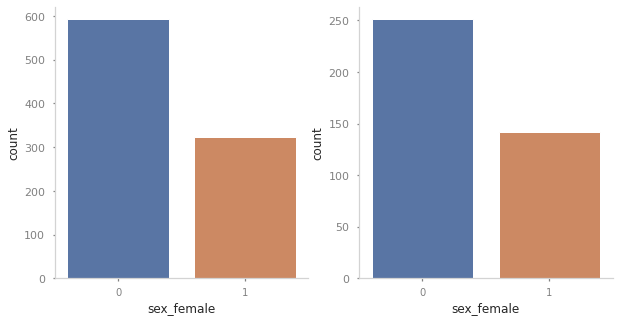

In [68]:
# Using train_test_split without stratifying
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(1, 2)

for data, axis in [(X_train, fig.add_subplot(gs[0])), (X_test, fig.add_subplot(gs[1]))]:
    sns.countplot('sex_female', data=data, ax=axis)

In [51]:
X_train

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
1214,3,NaN,0,0,8.6625,0,0,0,1
677,3,26.0,0,0,7.8958,0,0,0,1
534,2,19.0,0,0,26.0000,1,0,0,1
1174,3,NaN,8,2,69.5500,1,0,0,1
864,3,28.0,0,0,7.7750,1,0,0,1
...,...,...,...,...,...,...,...,...,...
1095,3,NaN,0,0,7.6292,1,0,1,0
1130,3,18.0,0,0,7.7750,1,0,0,1
1294,3,28.5,0,0,16.1000,0,0,0,1
860,3,26.0,0,0,7.9250,1,0,0,1
